This is the start 
For a comprehensive tutorial from gammapy, one can follow https://docs.gammapy.org/0.19/tutorials/analysis/1D/spectral_analysis.html

Here we break the post-DL3 analyses to simple and separate sections to ease the facilitation of all steps - 
# 1. Reduce DL3 data into Spectrum Dataset objects in OGIP files
# 2. Plot LC from the OGIP files
# 3. Plot SEDs from the OGIP files

# This example notebook, converts the provided DL3 files (with fixed global cuts) into Spectrum Dataset objects and saves the 1D counts spectra and Associated Response Function in OGIP format, as following:

## 1. Read the provided DL3 index files
## 2. Apply selection filters to the list of DL3 files
## 3. Define base geometry for the 1D spectrum
## 4. Generate some dataset makers for data reduction
## 5. Perform data reduction over all selected observations and compile them to a Dataset
## 6. Save the Dataset to OGIP files

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from regions import CircleSkyRegion, PointSkyRegion
from pathlib import Path
import os

In [2]:
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.visualization import plot_spectrum_datasets_off_regions

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u

# 1. Parameters from user for selection of observations

In [3]:
# Use the DL3 files produced for source dependent or independent analyses
base_dir = "/fefs/aswg/workspace/analysis-school-2022/DL3/"
dir_path = base_dir + "Crab_src_indep/"

If the DL3 index files are note present, run the lstchain_create_dl3_index_files for the given DL3 files

In [4]:
!lstchain_create_dl3_index_files -d $dir_path --overwrite

2022-01-27 19:40:19,323 WARNING [ctapipe.FITSIndexWriter] (lstchain_create_dl3_index_files.setup): Overwriting /fefs/aswg/workspace/analysis-school-2022/DL3/Crab_src_indep/hdu-index.fits.gz
2022-01-27 19:40:19,324 WARNING [ctapipe.FITSIndexWriter] (lstchain_create_dl3_index_files.setup): Overwriting /fefs/aswg/workspace/analysis-school-2022/DL3/Crab_src_indep/obs-index.fits.gz
Run 2967 does not contain HDU BACKGROUND
Run 2967 does not contain HDU PSF
Run 2967 does not contain HDU GH_CUTS
Run 2967 does not contain HDU RAD_MAX
Run 2968 does not contain HDU BACKGROUND
Run 2968 does not contain HDU PSF
Run 2968 does not contain HDU GH_CUTS
Run 2968 does not contain HDU RAD_MAX
Run 2969 does not contain HDU BACKGROUND
Run 2969 does not contain HDU PSF
Run 2969 does not contain HDU GH_CUTS
Run 2969 does not contain HDU RAD_MAX
Run 2970 does not contain HDU BACKGROUND
Run 2970 does not contain HDU PSF
Run 2970 does not contain HDU GH_CUTS
Run 2970 does not contain HDU RAD_MAX
Run 2971 does no

In [5]:
total_datastore = DataStore.from_dir(dir_path)

ogip_path = Path(dir_path + 'OGIP/')

# Create the Paths if they do not exist already
ogip_path.mkdir(exist_ok=True)

# 2. Selection filters for the observations

In [6]:
# Get the object name from the OBS Table, assuming all the DL3 files are of the same single source.
# If not, then select a single object, to produce the relevant Spectrum Dataset file

obj_name = np.unique(total_datastore.obs_table["OBJECT"])[0]
print("The source is", obj_name)

max_zen = 30 # in deg for a maximum limit on zenith pointing of observations
min_time = 300 # in seconds for minimum livetime of each observation

The source is Crab


In [7]:
total_obs_list = total_datastore.obs_table["OBS_ID"].data
observations_total = total_datastore.get_observations(
    total_obs_list, 
    required_irf=["aeff", "edisp"], # By default, "all" = ["aeff", "edisp", "bkg", "psf"]. 
                        # If not all IRFs are present, the entry will be skipped 
    skip_missing=False # Skip missing observations, within the list provided earlier
)

No HDU found matching: OBS_ID = 2967, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = bkg, HDU_CLA

In [8]:
# If you want to see the full Obs table, run this cell
total_datastore.obs_table

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes5,bytes5
2967,2020-11-21,00:27:41.949,2020-11-21,00:47:39.583,83.97004257137505,22.24530742887652,29.732219820109158,60.26778017989084,95.17577361000707,83.63308333,22.0145,1605918461.948865,1605919659.583141,1196.639870882034,1197.634275913239,1149.988205508068,0.9610144484492402,Crab,WOBBLE,1,LST-1,LST-1
2968,2020-11-21,00:49:07.551,2020-11-21,01:08:52.833,83.26649188127247,21.78727828475309,24.644129286465912,65.35587071353409,100.4389391756115,83.63308333,22.0145,1605919747.551059,1605920932.833492,1182.285777568817,1185.282433271408,1134.331009923455,0.9594389372221211,Crab,WOBBLE,1,LST-1,LST-1
2969,2020-11-21,01:10:05.044,2020-11-21,01:29:48.847,83.97196330127397,22.24484450444434,20.576248490410606,69.4237515095894,103.5294881362074,83.63308333,22.0145,1605921005.043805,1605922188.846951,1181.815325260162,1183.803146123886,1132.395291687877,0.9581829474402809,Crab,WOBBLE,1,LST-1,LST-1
2970,2020-11-21,01:31:05.784,2020-11-21,01:50:48.103,83.26926193186183,21.78671531937169,15.806710775486678,74.19328922451332,112.7274981260833,83.63308333,22.0145,1605922265.783684,1605923448.10268,1180.322825431824,1182.31899523735,1129.404207074757,0.9568604306720593,Crab,WOBBLE,1,LST-1,LST-1
2971,2020-11-21,01:52:06.553,2020-11-21,02:11:57.547,83.97488474600792,22.24478141506711,11.974578308930873,78.02542169106913,120.7416399361625,83.63308333,22.0145,1605923526.552607,1605924717.547404,1189.995587110519,1190.994797468185,1137.239771866555,0.9556672177482076,Crab,WOBBLE,1,LST-1,LST-1
2972,2020-11-21,02:13:04.303,2020-11-21,02:32:51.148,83.26938274609692,21.78637577536815,8.456185607133747,81.54381439286625,145.5424713719346,83.63308333,22.0145,1605924784.303458,1605925971.14784,1185.846040725708,1186.84438252449,1132.911096118316,0.9553610310365438,Crab,WOBBLE,1,LST-1,LST-1
2973,2020-11-21,02:34:12.986,2020-11-21,02:53:58.082,83.97788837191327,22.24392982902823,6.650280392114226,83.34971960788577,175.3413477815111,83.63308333,22.0145,1605926052.986249,1605927238.082328,1184.09685921669,1185.096079111099,1131.106187027389,0.9552480257194873,Crab,WOBBLE,1,LST-1,LST-1
2974,2020-11-21,02:55:10.354,2020-11-21,03:15:02.371,83.2715938922083,21.78635039916637,8.551754635131715,81.44824536486828,215.4690377991381,83.63308333,22.0145,1605927310.353878,1605928502.371439,1191.018638849258,1192.017561435699,1137.902026660467,0.9554023669687387,Crab,WOBBLE,1,LST-1,LST-1


In [9]:
# If you want to see the full HDU table, run this cell
total_datastore.hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,bytes8,bytes8,bytes1,bytes26,bytes17,int64
2967,events,events,.,dl3_LST-1.Run02967.fits.gz,EVENTS,46273096
2967,gti,gti,.,dl3_LST-1.Run02967.fits.gz,GTI,46273096
2967,pointing,pointing,.,dl3_LST-1.Run02967.fits.gz,POINTING,46273096
2967,aeff,aeff_2d,.,dl3_LST-1.Run02967.fits.gz,EFFECTIVE AREA,46273096
2967,edisp,edisp_2d,.,dl3_LST-1.Run02967.fits.gz,ENERGY DISPERSION,46273096
2968,events,events,.,dl3_LST-1.Run02968.fits.gz,EVENTS,48726839
2968,gti,gti,.,dl3_LST-1.Run02968.fits.gz,GTI,48726839
2968,pointing,pointing,.,dl3_LST-1.Run02968.fits.gz,POINTING,48726839
2968,aeff,aeff_2d,.,dl3_LST-1.Run02968.fits.gz,EFFECTIVE AREA,48726839


# 3. Make selection of observations

In [10]:
d_wob = [total_datastore.obs_table["OBS_MODE"]=='WOBBLE']

d_time = [total_datastore.obs_table["LIVETIME"]>min_time]
d_zen = [total_datastore.obs_table["ZEN_PNT"]<max_zen]
d_obj = [total_datastore.obs_table["OBJECT"]==obj_name]

wob_obs_table = total_datastore.obs_table[d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]]
wob_obs_list = total_datastore.obs_table[d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]]["OBS_ID"]

observations_wob = total_datastore.get_observations(
    wob_obs_list.data, 
    required_irf=["aeff", "edisp"]
)

No HDU found matching: OBS_ID = 2967, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = bkg, HDU_CLA

In [11]:
print('Wobble observation runs selected are:', wob_obs_list.data)
print(f'Total livetime of all observations: {total_datastore.obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')
print(f'Total livetime of all selected wobble observations {wob_obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')

Wobble observation runs selected are: [2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977]
Total livetime of all observations: 3.461 hrs
Total livetime of all selected wobble observations 3.461 hrs


# 4. Define Target position and energy ranges for reconstructed events

In [12]:
target_position = SkyCoord.from_name(obj_name, frame='icrs')

In [13]:
# A long way to find the fixed global theta cut used for creating the IRFs

# Select the HDU entry of the first selected wobble observation
hdu_t = total_datastore.hdu_table
hdu_idx = np.where(hdu_t["OBS_ID"] == wob_obs_list[0])[0][0]

hdu_sel = hdu_t[hdu_idx]
print("Base directory of the HDU index file,", hdu_sel.meta["BASE_DIR"])
print("Location of the selected DL3 file, with respect to HDU index file,", hdu_sel["FILE_DIR"])
print("File name of the selected observation,", hdu_sel["FILE_NAME"])

file = Path(hdu_sel.meta["BASE_DIR"]) / hdu_sel["FILE_DIR"] / hdu_sel["FILE_NAME"]

# Checking the fixed global theta cut value, stored as RAD_MAX metadata in all IRF HDUs
theta_cut = Table.read(file, hdu="EFFECTIVE AREA").meta["RAD_MAX"]
print("Theta cut applied for creating the IRF in the selected DL3 file,", theta_cut)

# Converting the value into astropy.units
## Earlier, there was mistake in storing the RAD_MAX header value as string. It should be stored as float, in deg.
## Use the commented line for getting the right assignment of on_region_radius
on_region_radius = u.Quantity(theta_cut)

Base directory of the HDU index file, /fefs/aswg/workspace/analysis-school-2022/DL3/Crab_src_indep
Location of the selected DL3 file, with respect to HDU index file, .
File name of the selected observation, dl3_LST-1.Run02967.fits.gz
Theta cut applied for creating the IRF in the selected DL3 file, 0.2 deg


In [14]:
# Provide the minimum, maximum energies in TeV units, and number of bins per decade, to create the 
# required reconstructed and spectral fit energy ranges.

e_reco_min = 0.01
e_reco_max = 40

e_true_min = 0.01
e_true_max = 100

energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=5, per_decade=True, 
    unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=10, per_decade=True, 
    unit="TeV", name="energy_true"
)


# 5. Define the base Map geometries for creating the SpectrumDataset

In [15]:
on_region = CircleSkyRegion(target_position, radius=on_region_radius)

# This will create the base geometry in which to bin the events based on their reconstructed positions
on_geom = RegionGeom.create(
    on_region, axes=[energy_axis]
)

/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


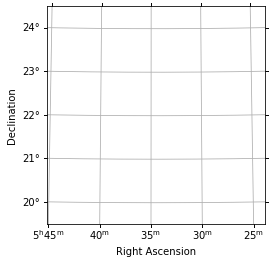

In [16]:
# Exclusion region/source for Crab - RGB J0521+212. 
# Can include specific close gamma-ray objects with respect to the given source, after looking at catalogs
# like http://gamma-sky.net/

# If need be, one can also modify the size of the region, in the previous cell, to exclude some regions
exclusion_region = CircleSkyRegion(
    center=SkyCoord.from_name("RGB J0521+212", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
excluded_geom = WcsGeom.create(
    npix=(100, 100), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~excluded_geom.region_mask([exclusion_region])
exclusion_mask.plot();
plt.grid()

# 6. Data Reduction chain

In [17]:
# Create some Dataset and Data Reduction Makers
# geom is the target geometry in reco energy for counts and background maps
# energy_axis_true is the true energy axis for the IRF maps
dataset_empty = SpectrumDataset.create(
    geom=on_geom, energy_axis_true=energy_axis_true
)
# When not including a PSF IRF, put the containment_correction as False
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, 
    selection=["counts", "exposure", "edisp"]
)

In [18]:
# The following makers can be tuned and played to check the final Dataset to be used.

# Select the necessary number and size of the OFF regions, to be chosen by this method

bkg_maker = ReflectedRegionsBackgroundMaker(
    exclusion_mask=exclusion_mask,
    min_distance=1.5 * u.rad, # Minimum distance from input region
    max_region_number=1 # Maximum number of OFF regions
) 

# Can also include other parameters, by checking the documentation,
# https://docs.gammapy.org/0.19/api/gammapy.makers.ReflectedRegionsBackgroundMaker.html#gammapy.makers.ReflectedRegionsBackgroundMaker

In [19]:
# Maker for safe energy range for the events.
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-max"], 
    aeff_percent=10
)
# For other arguments and options, check the documentation,
# https://docs.gammapy.org/0.19/api/gammapy.makers.SafeMaskMaker.html#gammapy.makers.SafeMaskMaker

# 7. Generate the Spectrum Dataset for all observations

In [20]:
%%time
# The final object will be stored as a Datasets object

# There will be an error message on use_region_center=False. It is a bug message in gammapy, so just ignore it
datasets = Datasets()

for obs_id, observation in zip(wob_obs_list, observations_wob):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), 
        observation
    )
    print('obs_id:', obs_id)
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    
    # Add the name of the observed source
    dataset_on_off.meta_table["SOURCE"]=obj_name
    
    # Check the LC and SEDs by applying the safe mask to see the distinction.
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    
    datasets.append(dataset_on_off)    

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2967


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2968


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2969


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2970


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2971


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2972


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2973


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2974


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2975


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2976


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2977
CPU times: user 1min 41s, sys: 14.9 s, total: 1min 56s
Wall time: 1min 56s


In [21]:
print(datasets[0])

SpectrumDatasetOnOff
--------------------

  Name                            : 2967 

  Total counts                    : 2980 
  Total background counts         : 2114.00
  Total excess counts             : 866.00

  Predicted counts                : 2547.00
  Predicted background counts     : 2547.00
  Predicted excess counts         : nan

  Exposure min                    : 7.30e+04 m2 s
  Exposure max                    : 3.71e+08 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 14 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 256.20

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 6373 
  Acceptance                      : 19 
  Acceptance off                  : 19 



# 8. Some plots with the given Dataset

/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


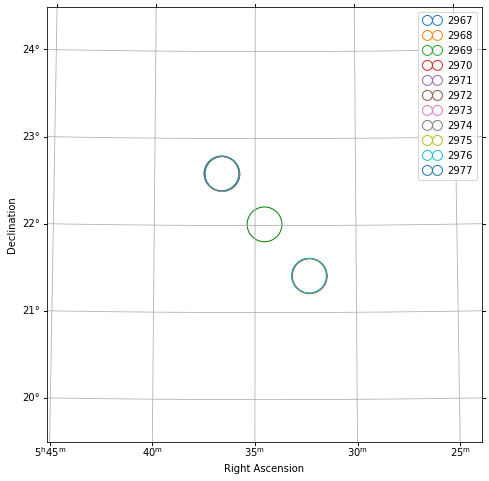

In [22]:
# Check the OFF regions used for calculation of excess
plt.figure(figsize=(8, 8))
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax)
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets, legend=True)
plt.grid()

# If need be, redo section 7 and 8, to be sure of the final dataset.
# This could be in the case of using source-dependent dataset

In [23]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,2980,2114.0,866.0,12.163095263658246,2547.0,2547.0,nan,72977.8984375,370646048.0,1150.9438431106662,1197.6342759132385,2.5891793225514177,1.836753385192516,0.752425937358902,19,14,wstat,256.20203197386917,2114,14.0,14.0,1.0
stacked,6024,4315.0,1709.0,16.84613659914232,5169.5,5169.5,nan,145084.71875,736868032.0,2288.1499611966356,2382.9167091846466,2.632694579532551,1.8858029732209427,0.7468916063116086,19,14,wstat,504.3791274628895,4315,14.0,14.0,1.0
stacked,9092,6618.0,2474.0,19.77954383724778,7855.0,7855.0,nan,217007.28125,1102154112.0,3422.449948938698,3566.7198553085327,2.656576468801079,1.9337024934585945,0.7228739753424845,19,14,wstat,730.8194150586186,6618,14.0,14.0,1.0
stacked,12202,9029.0,3173.0,21.81719854354231,10615.5,10615.5,nan,288740.53125,1466478720.0,4553.764211913265,4749.038850545883,2.679541458927081,1.982755272303935,0.6967861866231461,19,14,wstat,887.4987253197083,9029,14.0,14.0,1.0
stacked,15313,11486.0,3827.0,23.417580815824785,13399.5,13399.5,nan,360910.0625,1833019136.0,5691.9588963622755,5940.033648014069,2.6902864688264914,2.0179344596709385,0.672352009155553,19,14,wstat,1052.7762339798965,11486,14.0,14.0,1.0
stacked,18564,13914.0,4650.0,25.84669713059399,16239.0,16239.0,nan,432805.03125,2198164992.0,6825.823769330803,7126.878030538559,2.719671738876434,2.0384352819826925,0.6812364568937416,19,14,wstat,1261.1950232786796,13914,14.0,14.0,1.0
stacked,21670,16462.0,5208.0,26.7119322734397,19066.0,19066.0,nan,504585.625,2562729984.0,7957.884459189586,8311.974109649658,2.723085527457737,2.068640237794613,0.6544452896631239,19,14,wstat,1396.2070923495253,16462,14.0,14.0,1.0
stacked,24828,18850.0,5978.0,28.648806556492474,21839.0,21839.0,nan,576797.125,2929483520.0,9096.740858853556,9503.991671085358,2.729329150432567,2.0721707139380494,0.6571584364945178,19,14,wstat,1552.3666458034381,18850,14.0,14.0,1.0


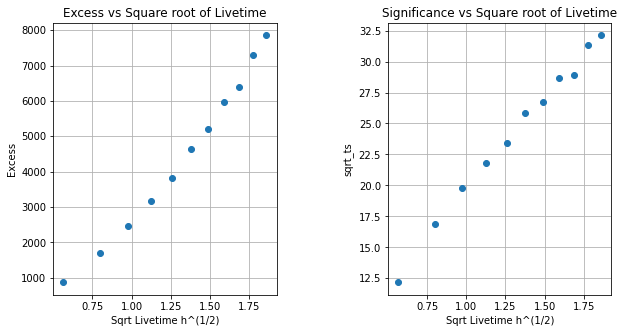

In [24]:
# Plot temporal evolution of excess events and significance value
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["excess"], marker="o", ls="none"
)
plt.plot(info_table["livetime"].to("h")[-1:1], info_table["excess"][-1:1], 'r')
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("Excess")
plt.grid()
plt.title('Excess vs Square root of Livetime')

plt.subplot(122)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.grid()
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("sqrt_ts")
plt.title('Significance vs Square root of Livetime')
plt.subplots_adjust(wspace=0.5)


CPU times: user 1.09 s, sys: 17.9 ms, total: 1.11 s
Wall time: 1.11 s


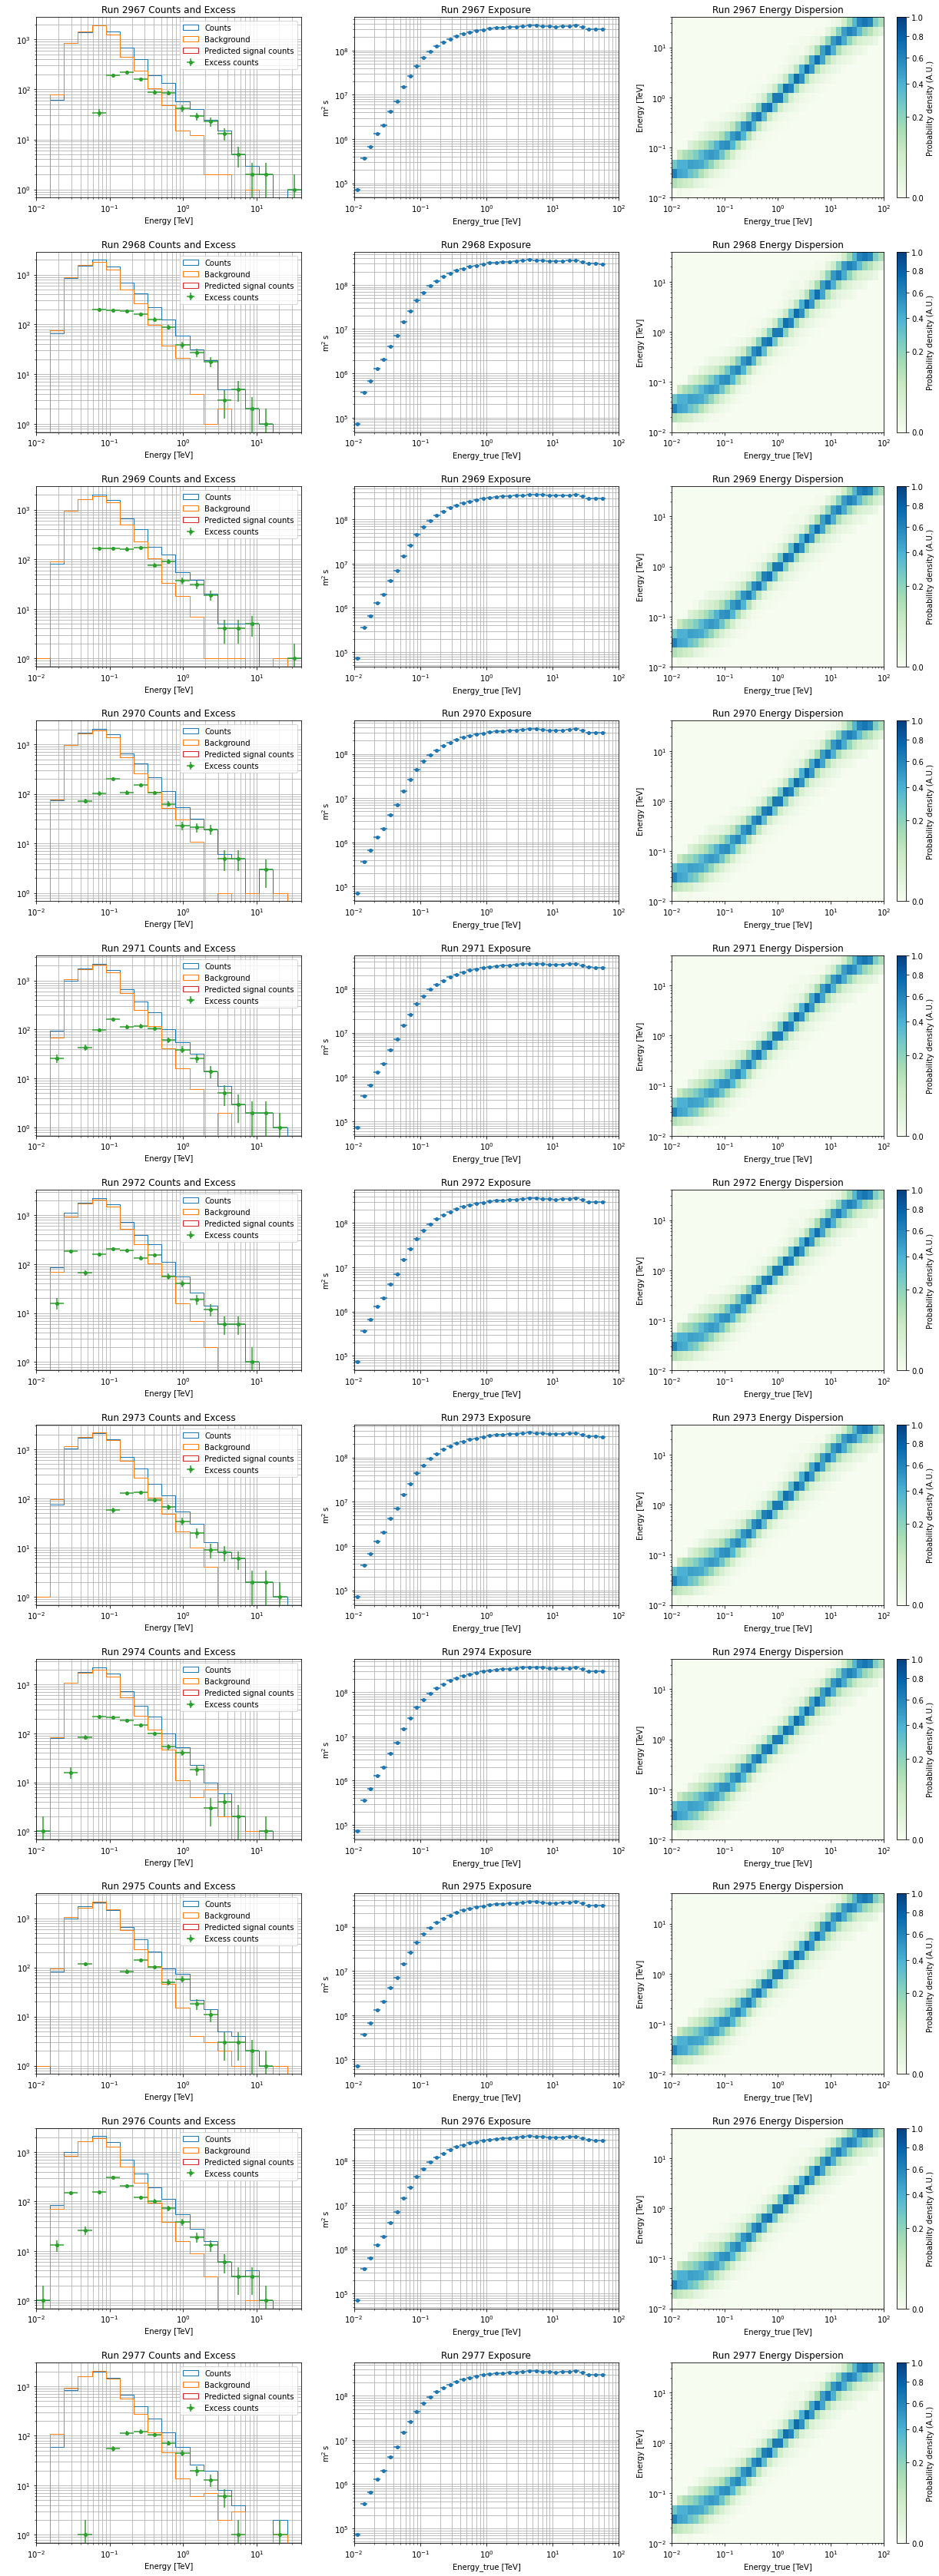

In [25]:
%%time
# Plot the counts+excess, exposure and energy migration of each selected dataset
plt.figure(figsize=(21, len(datasets)*5.5))
j=1

for data in datasets:
    plt.subplot(len(datasets), 3, j)
    data.plot_counts()
    data.plot_excess()
    plt.grid(which="both")
    plt.title(f'Run {data.name} Counts and Excess')
    j += 1
    
    plt.subplot(len(datasets), 3, j)
    data.exposure.plot()
    plt.grid(which='both')
    plt.title(f'Run {data.name} Exposure')
    j += 1
    
    plt.subplot(len(datasets), 3, j)
    if data.edisp is not None:
        kernel = data.edisp.get_edisp_kernel()
        kernel.plot_matrix(add_cbar=True)
        plt.title(f'Run {data.name} Energy Dispersion')
    j += 1
plt.subplots_adjust(hspace=0.3)

# 9. Write all datasets into OGIP files

In [26]:
# Once the latest dependencies are updated, these warnings will go away
for d in datasets:
    d.write(
        filename=ogip_path / f"obs_{d.name}.fits.gz", overwrite=True
    )

In [27]:
# Read the OGIP files to include the source object name in its headers, to be used for further analysis
for obs in wob_obs_list:
    file = ogip_path/f"obs_{obs}.fits.gz"
    
    d1 = fits.open(file)
    d1["REGION"].header["OBJECT"]=obj_name
    d1.writeto(file, overwrite=True)